# Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy
import researchpy as rp
import os
import time


import seaborn as sns
from copy import deepcopy

import itertools
from collections.abc import Iterable

import traceback

sns.set_style("darkgrid")

pd.set_option('max_columns', 50)

import warnings

warnings.filterwarnings('ignore')

timestr = time.strftime("%Y%m%d-%H%M%S")

# Function Definitions

In [2]:
def flatten_list(l):
    
    def flatten(l):
        for el in l:
            if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
                yield from flatten(el)
            else:
                yield el
                
    flat_l = flatten(l)
    
    return list(flat_l)


def get_relevant_columns_by_config(config, dataframe):
    try:
        if config['i_net_nas'] == False:
            config.pop('i_net_nas_trials')
    except:
        pass
    
    for key, value in config.items():
        try:
            if isinstance(value, list):
                if isinstance(value[0], str):
                    dataframe_string_query = key + ' == "' + str(value[0]) + '"'
                    for dataframe_string in value[1:]:
                        dataframe_string_query += ' | ' + key + ' == "' + str(dataframe_string) + '"'

                    dataframe = dataframe.query(dataframe_string_query)
                else:
                    dataframe = dataframe[dataframe[key].isin(value)]
                    
            else:
                dataframe = dataframe[dataframe[key] == value]
        except:
            traceback.print_exc()
        
    return dataframe


def plot_results(data_reduced, col, x, y, hue, plot_type=sns.barplot, aspect=1.5, col_wrap=2):
    
    #sns.set(rc={'figure.figsize':(20,10)})
    
    g = sns.FacetGrid(data_reduced, 
                      col=col,
                      ##hue='scores_type', 
                      #height=5, 
                      col_wrap=col_wrap,
                      aspect=aspect,
                      ##legend_out=False,
                     )    
    indexes = np.unique(data_reduced[hue], return_index=True)[1]
    hue_order = [data_reduced[hue].values[index] for index in sorted(indexes)]
        
    g.map(plot_type, 
          x, 
          y, 
          hue,
          hue_order=hue_order,#np.unique(data_reduced[hue]),
          ##figsize=(20,10),
          palette=sns.color_palette(),#'colorblind'
          #order=data_reduced[order_columnname],
          ##order=np.unique(results_summary_reduced_accuracy_plot["scores_type"]),
         )
    g.add_legend(fontsize=12,
               ncol=3,
               bbox_to_anchor=(0.5, -0.025),
               borderaxespad=0)    
    
    return plt.gcf()


def add_hline(latex: str, index: int) -> str:
    """
    Adds a horizontal `index` lines before the last line of the table

    Args:
        latex: latex table
        index: index of horizontal line insertion (in lines)
    """
    lines = latex.splitlines()
    lines.insert(len(lines) - index - 2, r'\midrule')
    return '\n'.join(lines)#.replace('NaN', '')

# Prepare Results Data 

## Loading Files

In [3]:
#results_complete = pd.read_csv('./results_complete.csv', delimiter=';')
#results_complete = results_complete[results_complete['i_net_nas'] == True]
#results_complete_columns = list(results_complete.columns)

#results_summary = pd.read_csv('./results_summary-TEST.csv', delimiter=';')
results_summary = pd.read_csv('./results_summary.csv', delimiter=';')
#results_summary = results_summary[results_summary['i_net_nas'] == True]
results_summary_columns = list(results_summary.columns)
results_summary['function_family_decision_sparsity'][results_summary['data_number_of_variables'] == results_summary['function_family_decision_sparsity']] = -1

print(results_summary.shape)
results_summary.head(5)

(28, 10004)


,function_family_maximum_depth,function_family_beta,function_family_decision_sparsity,function_family_fully_grown,function_family_dt_type,function_family_basic_function_representation_length,function_family_function_representation_length,data_number_of_variables,data_num_classes,data_categorical_indices,data_use_distribution_list,data_random_parameters_distribution,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,data_dt_type_train,data_maximum_depth_train,data_decision_sparsity_train,data_function_generation_type,data_distribution_list,data_distribution_list_eval,data_objective,...,max_distance_to_neuron_average_Brest Cancer Wisconsin,max_distance_to_neuron_average_Wisconsin Diagnostic Breast Cancer,max_distance_to_neuron_average_Wisconsin Prognostic Breast Cancer,max_distance_to_neuron_average_Abalone,max_distance_to_neuron_average_Car,max_distance_to_neuron_average_train,max_distance_to_neuron_average_valid,max_distance_to_neuron_average_test,max_distance_to_neuron_min_Adult,max_distance_to_neuron_min_Titanic,max_distance_to_neuron_min_Absenteeism,max_distance_to_neuron_min_Loan House,max_distance_to_neuron_min_Loan Credit,max_distance_to_neuron_min_Medical Insurance,max_distance_to_neuron_min_Bank Marketing,max_distance_to_neuron_min_Cervical Cancer,max_distance_to_neuron_min_Brest Cancer Wisconsin,max_distance_to_neuron_min_Wisconsin Diagnostic Breast Cancer,max_distance_to_neuron_min_Wisconsin Prognostic Breast Cancer,max_distance_to_neuron_min_Abalone,max_distance_to_neuron_min_Car,max_distance_to_neuron_min_train,max_distance_to_neuron_min_valid,max_distance_to_neuron_min_test,Unnamed: 10003
0,3,1,1,True,vanilla,22,414,29,2,[],True,True,1,True,False,False,False,False,vanilla,3,1,distribution,"['uniform', 'normal', 'gamma', 'beta', 'poisson']","['uniform', 'normal', 'gamma', 'beta', 'poisson']",classification,...,NaN,NaN,NaN,NaN,NaN,3.221852,2.852807,2.873230,NaN,NaN,NaN,NaN,NaN,NaN,4.307041,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.566248,1.721461,NaN
1,3,1,1,True,vanilla,22,134,9,2,[],True,True,1,True,False,False,False,False,vanilla,3,1,distribution,"['uniform', 'normal', 'gamma', 'beta', 'poisson']","['uniform', 'normal', 'gamma', 'beta', 'poisson']",classification,...,4.396721,NaN,NaN,NaN,NaN,4.963170,5.986595,5.853193,NaN,1.194644,NaN,NaN,NaN,3.617012,NaN,NaN,1.599454,NaN,NaN,NaN,NaN,0.0,3.183948,3.057928,NaN
2,3,1,1,True,vanilla,22,218,15,2,[],True,True,1,True,False,False,False,False,vanilla,3,1,distribution,"['uniform', 'normal', 'gamma', 'beta', 'poisson']","['uniform', 'normal', 'gamma', 'beta', 'poisson']",classification,...,NaN,NaN,NaN,NaN,NaN,4.753990,4.834689,4.448376,NaN,NaN,0.297183,NaN,NaN,NaN,NaN,1.395832,NaN,NaN,NaN,NaN,NaN,0.0,2.716410,2.503532,NaN
3,3,1,1,True,vanilla,22,456,32,2,[],True,True,1,True,False,False,False,False,vanilla,3,1,distribution,"['uniform', 'normal', 'gamma', 'beta', 'poisson']","['uniform', 'normal', 'gamma', 'beta', 'poisson']",classification,...,NaN,NaN,NaN,NaN,NaN,3.303530,2.933454,2.831606,NaN,NaN,NaN,NaN,10.300163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.610263,1.657743,NaN
4,3,1,1,True,vanilla,22,148,10,2,[],True,True,1,True,False,False,False,False,vanilla,3,1,distribution,"['uniform', 'normal', 'gamma', 'beta', 'poisson']","['uniform', 'normal', 'gamma', 'beta', 'poisson']",classification,...,NaN,6.645471,4.039354,4.148277,NaN,5.295377,5.311839,5.993409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.699019,0.763728,1.21548,NaN,0.0,2.589264,3.338031,NaN


### Select columns

In [4]:
colmuns_identifier = [
                  'function_family_maximum_depth',
                  'function_family_decision_sparsity', 
                  'function_family_dt_type',
    
                  'data_dt_type_train',
                  'data_maximum_depth_train',
                  'data_number_of_variables',
                  'data_noise_injected_level',
                  'data_function_generation_type',
                  'data_categorical_indices',
                    
                  'data_exclude_linearly_seperable', 
                  'data_data_generation_filtering', 
                  'data_fixed_class_probability', 
                  'data_weighted_data_generation', 
                  'data_shift_distrib',
      
                  'lambda_net_lambda_network_layers',
                  'lambda_net_optimizer_lambda',
    
                  'i_net_dense_layers',
                  'i_net_dropout',
                  'i_net_learning_rate',
                  'i_net_loss',
                  'i_net_interpretation_dataset_size',
                  'i_net_function_representation_type',
                  'i_net_data_reshape_version',
                  'i_net_nas',
                  'i_net_nas_trials',
    
                  'evaluation_eval_data_description_eval_data_function_generation_type',
                  'evaluation_eval_data_description_eval_data_noise_injected_level',
    
                  'evaluation_number_of_random_evaluations_per_distribution',
                 ]


In [5]:
columns_inet = []
for column in results_summary_columns:
    if 'inet_scores' in column:
        columns_inet.append(column)
results_summary_inet = results_summary[flatten_list([colmuns_identifier, columns_inet])]

results_summary_inet.head(10)

,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,i_net_dense_layers,i_net_dropout,i_net_learning_rate,i_net_loss,i_net_interpretation_dataset_size,i_net_function_representation_type,i_net_data_reshape_version,i_net_nas,i_net_nas_trials,...,inet_scores_soft_binary_crossentropy_Brest Cancer Wisconsin_TRAIN_DATA,inet_scores_binary_crossentropy_Brest Cancer Wisconsin_TRAIN_DATA,inet_scores_accuracy_Brest Cancer Wisconsin_TRAIN_DATA,inet_scores_f1_score_Brest Cancer Wisconsin_TRAIN_DATA,inet_scores_runtime_Brest Cancer Wisconsin_TRAIN_DATA,inet_scores_soft_binary_crossentropy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,inet_scores_binary_crossentropy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,inet_scores_accuracy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,inet_scores_f1_score_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,inet_scores_runtime_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,inet_scores_soft_binary_crossentropy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,inet_scores_binary_crossentropy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,inet_scores_accuracy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,inet_scores_f1_score_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,inet_scores_runtime_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,inet_scores_soft_binary_crossentropy_Abalone_TRAIN_DATA,inet_scores_binary_crossentropy_Abalone_TRAIN_DATA,inet_scores_accuracy_Abalone_TRAIN_DATA,inet_scores_f1_score_Abalone_TRAIN_DATA,inet_scores_runtime_Abalone_TRAIN_DATA,inet_scores_soft_binary_crossentropy_Car_TRAIN_DATA,inet_scores_binary_crossentropy_Car_TRAIN_DATA,inet_scores_accuracy_Car_TRAIN_DATA,inet_scores_f1_score_Car_TRAIN_DATA,inet_scores_runtime_Car_TRAIN_DATA
0,3,1,vanilla,vanilla,3,29,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,1,vanilla,vanilla,3,9,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,0.558346,0.441383,0.927536,0.883721,0.124016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,vanilla,vanilla,3,15,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,vanilla,vanilla,3,32,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1,vanilla,vanilla,3,10,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,0.56254,0.481708,0.803571,0.47619,0.13484,0.646664,0.587194,0.684211,0.666667,0.125079,0.669019,0.641222,0.661871,0.0,0.149988,NaN,NaN,NaN,NaN,NaN
5,3,1,vanilla,vanilla,3,28,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,1,vanilla,vanilla,3,16,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,False,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
columns_inet = []
for column in results_summary_columns:
    if 'inet_scores' in column:
        columns_inet.append(column)
results_summary_inet = results_summary[flatten_list([colmuns_identifier, columns_inet])]

columns_inet_rename = []
for column in columns_inet:
    column = column.replace('inet_scores_', '')
    columns_inet_rename.append(column)

results_summary_inet.columns = flatten_list([colmuns_identifier, columns_inet_rename])

#results_summary_inet.insert(0, 'scores_type', 'inet_scores')
results_summary_inet.insert(0, 'dt_type', [dt_type + str(decision_sparsity) for dt_type, decision_sparsity in zip(results_summary_inet['function_family_dt_type'].values, results_summary_inet['function_family_decision_sparsity'].values)])
results_summary_inet.insert(0, 'technique', ['inet' for _ in range(results_summary_inet.shape[0])])

    
print(results_summary_inet.shape)
results_summary_inet.head(20)

(28, 815)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,i_net_dense_layers,i_net_dropout,i_net_learning_rate,i_net_loss,i_net_interpretation_dataset_size,i_net_function_representation_type,i_net_data_reshape_version,...,soft_binary_crossentropy_Brest Cancer Wisconsin_TRAIN_DATA,binary_crossentropy_Brest Cancer Wisconsin_TRAIN_DATA,accuracy_Brest Cancer Wisconsin_TRAIN_DATA,f1_score_Brest Cancer Wisconsin_TRAIN_DATA,runtime_Brest Cancer Wisconsin_TRAIN_DATA,soft_binary_crossentropy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,binary_crossentropy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,accuracy_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,f1_score_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,runtime_Wisconsin Diagnostic Breast Cancer_TRAIN_DATA,soft_binary_crossentropy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,binary_crossentropy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,accuracy_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,f1_score_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,runtime_Wisconsin Prognostic Breast Cancer_TRAIN_DATA,soft_binary_crossentropy_Abalone_TRAIN_DATA,binary_crossentropy_Abalone_TRAIN_DATA,accuracy_Abalone_TRAIN_DATA,f1_score_Abalone_TRAIN_DATA,runtime_Abalone_TRAIN_DATA,soft_binary_crossentropy_Car_TRAIN_DATA,binary_crossentropy_Car_TRAIN_DATA,accuracy_Car_TRAIN_DATA,f1_score_Car_TRAIN_DATA,runtime_Car_TRAIN_DATA
0,inet,vanilla1,3,1,vanilla,vanilla,3,29,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,inet,vanilla1,3,1,vanilla,vanilla,3,9,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,0.558346,0.441383,0.927536,0.883721,0.124016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,inet,vanilla1,3,1,vanilla,vanilla,3,15,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,inet,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,inet,vanilla1,3,1,vanilla,vanilla,3,10,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,0.562540,0.481708,0.803571,0.476190,0.134840,0.646664,0.587194,0.684211,0.666667,0.125079,0.669019,0.641222,0.661871,0.000000,0.149988,NaN,NaN,NaN,NaN,NaN
5,inet,vanilla1,3,1,vanilla,vanilla,3,28,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,inet,vanilla1,3,1,vanilla,vanilla,3,16,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,inet,SDT-1,3,-1,SDT,vanilla,3,16,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
columns_dt_distilled = []
for column in results_summary_columns:
    if 'dt_scores' in column:
        if 'data_random' not in column:
            columns_dt_distilled.append(column)
results_summary_dt_distilled = results_summary[flatten_list([colmuns_identifier, columns_dt_distilled])]

columns_dt_distilled_rename = []
for column in columns_dt_distilled:
    column = column.replace('dt_scores_','')
    columns_dt_distilled_rename.append(column)

results_summary_dt_distilled.columns = flatten_list([colmuns_identifier, columns_dt_distilled_rename])
    
#results_summary_dt_distilled.insert(0, 'scores_type', 'dt_scores')
results_summary_dt_distilled.insert(0, 'dt_type', [dt_type + str(decision_sparsity) for dt_type, decision_sparsity in zip(results_summary_dt_distilled['function_family_dt_type'].values, results_summary_dt_distilled['function_family_decision_sparsity'].values)])
results_summary_dt_distilled.insert(0, 'technique', ['distilled' for _ in range(results_summary_dt_distilled.shape[0])])

    
print(results_summary_dt_distilled.shape)
results_summary_dt_distilled.head(15)


(28, 5002)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,i_net_dense_layers,i_net_dropout,i_net_learning_rate,i_net_loss,i_net_interpretation_dataset_size,i_net_function_representation_type,i_net_data_reshape_version,...,runtime_normal_Car_TRAIN_DATA,soft_binary_crossentropy_gamma_Car_TRAIN_DATA,binary_crossentropy_gamma_Car_TRAIN_DATA,accuracy_gamma_Car_TRAIN_DATA,f1_score_gamma_Car_TRAIN_DATA,runtime_gamma_Car_TRAIN_DATA,soft_binary_crossentropy_beta_Car_TRAIN_DATA,binary_crossentropy_beta_Car_TRAIN_DATA,accuracy_beta_Car_TRAIN_DATA,f1_score_beta_Car_TRAIN_DATA,runtime_beta_Car_TRAIN_DATA,soft_binary_crossentropy_poisson_Car_TRAIN_DATA,binary_crossentropy_poisson_Car_TRAIN_DATA,accuracy_poisson_Car_TRAIN_DATA,f1_score_poisson_Car_TRAIN_DATA,runtime_poisson_Car_TRAIN_DATA,soft_binary_crossentropy_Car_TRAIN_DATA,binary_crossentropy_Car_TRAIN_DATA,accuracy_Car_TRAIN_DATA,f1_score_Car_TRAIN_DATA,soft_binary_crossentropy_std_Car_TRAIN_DATA,binary_crossentropy_std_Car_TRAIN_DATA,accuracy_std_Car_TRAIN_DATA,f1_score_std_Car_TRAIN_DATA,runtime_Car_TRAIN_DATA
0,distilled,vanilla1,3,1,vanilla,vanilla,3,29,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,distilled,vanilla1,3,1,vanilla,vanilla,3,9,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,distilled,vanilla1,3,1,vanilla,vanilla,3,15,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,distilled,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,distilled,vanilla1,3,1,vanilla,vanilla,3,10,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,distilled,vanilla1,3,1,vanilla,vanilla,3,28,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,distilled,vanilla1,3,1,vanilla,vanilla,3,16,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,distilled,SDT-1,3,-1,SDT,vanilla,3,16,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,distilled,SDT-1,3,-1,SDT,vanilla,3,15,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,distilled,SDT-1,3,-1

In [8]:
results_summary_inet.shape

(28, 815)

In [9]:
results_summary_dt_distilled.shape

(28, 5002)

In [10]:
results_summary_reduced = pd.concat([
                                     results_summary_inet, 
                                     results_summary_dt_distilled, 
                                    ]).reset_index(drop=True)
results_summary_reduced_columns = results_summary_reduced.columns
print(results_summary_reduced.shape)
results_summary_reduced.head(5)

(56, 5002)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,i_net_dense_layers,i_net_dropout,i_net_learning_rate,i_net_loss,i_net_interpretation_dataset_size,i_net_function_representation_type,i_net_data_reshape_version,...,runtime_uniform_Car_TRAIN_DATA,soft_binary_crossentropy_normal_Car_TRAIN_DATA,binary_crossentropy_normal_Car_TRAIN_DATA,accuracy_normal_Car_TRAIN_DATA,f1_score_normal_Car_TRAIN_DATA,runtime_normal_Car_TRAIN_DATA,soft_binary_crossentropy_gamma_Car_TRAIN_DATA,binary_crossentropy_gamma_Car_TRAIN_DATA,accuracy_gamma_Car_TRAIN_DATA,f1_score_gamma_Car_TRAIN_DATA,runtime_gamma_Car_TRAIN_DATA,soft_binary_crossentropy_beta_Car_TRAIN_DATA,binary_crossentropy_beta_Car_TRAIN_DATA,accuracy_beta_Car_TRAIN_DATA,f1_score_beta_Car_TRAIN_DATA,runtime_beta_Car_TRAIN_DATA,soft_binary_crossentropy_poisson_Car_TRAIN_DATA,binary_crossentropy_poisson_Car_TRAIN_DATA,accuracy_poisson_Car_TRAIN_DATA,f1_score_poisson_Car_TRAIN_DATA,runtime_poisson_Car_TRAIN_DATA,soft_binary_crossentropy_std_Car_TRAIN_DATA,binary_crossentropy_std_Car_TRAIN_DATA,accuracy_std_Car_TRAIN_DATA,f1_score_std_Car_TRAIN_DATA
0,inet,vanilla1,3,1,vanilla,vanilla,3,29,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,inet,vanilla1,3,1,vanilla,vanilla,3,9,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,inet,vanilla1,3,1,vanilla,vanilla,3,15,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,inet,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,inet,vanilla1,3,1,vanilla,vanilla,3,10,0,distribution,[],True,False,False,False,False,[128],adam,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,3,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Considered Results Specification

In [11]:
config = {
    'i_net_dense_layers': ['[1792, 512, 512]'], #['[1024, 1024, 256, 2048, 2048]'], # ['[2048, 1024]']
    'i_net_dropout': ['[0, 0, 0.5]'], #['[0, 0, 0, 0, 0.3]'], #
    
    'i_net_interpretation_dataset_size': [10000],
    
    'i_net_loss': 'binary_crossentropy', # 'binary_crossentropy', 'soft_binary_crossentropy'
    
    'data_exclude_linearly_seperable': True,
    'data_data_generation_filtering':  False, 
    'data_fixed_class_probability':  False, 
    'data_weighted_data_generation':  False, 
    'data_shift_distrib':  False, 
    
    #'data_noise_injected_level': 0, 
    #'data_data_noise': 0,

    'i_net_nas': False, # 'True', 'False'
    'i_net_nas_trials': 20, #20, 100

    #'data_number_of_variables': [unique_value], # [10]
    'function_family_maximum_depth': [3], # [3, 4, 5]
    
    'evaluation_number_of_random_evaluations_per_distribution': [10],
}

In [12]:
score_names_list = ['valid_accuracy', 'valid_binary_crossentropy', 'valid_f1_score']
valid_scores_columns = [name for name in results_summary_reduced_columns if 'valid' in name and any([score in name for score in score_names_list])]
valid_identifier_columns = ['dt_type', 'data_number_of_variables', 'technique']
valid_columns = flatten_list([valid_identifier_columns, valid_scores_columns])

print(results_summary_reduced.shape)
valid_scores_df = get_relevant_columns_by_config(config, results_summary_reduced)
valid_scores_df = valid_scores_df[valid_columns]
valid_scores_df = valid_scores_df.sort_values(['dt_type', 'data_number_of_variables', 'technique'], ascending=[True, True, True])
print(valid_scores_df.shape)
valid_scores_df.head(100)


(56, 5002)
(28, 9)


,dt_type,data_number_of_variables,technique,valid_binary_crossentropy,valid_binary_crossentropy_median,valid_accuracy,valid_accuracy_median,valid_f1_score,valid_f1_score_median
37,SDT-1,9,distilled,0.444135,0.347328,0.84416,0.8924,0.850463,0.886590
9,SDT-1,9,inet,0.445066,0.418332,0.82024,0.8556,0.805382,0.819295
38,SDT-1,10,distilled,0.382779,0.288879,0.87736,0.9136,0.864669,0.900931
10,SDT-1,10,inet,0.287350,0.263128,0.89544,0.9168,0.881869,0.895446
36,SDT-1,15,distilled,0.330982,0.331706,0.88544,0.9128,0.855422,0.922161
8,SDT-1,15,inet,0.358231,0.353238,0.86368,0.8808,0.865611,0.882576
35,SDT-1,16,distilled,0.342940,0.354882,0.88824,0.9208,0.877077,0.928943
7,SDT-1,16,inet,0.384697,0.350820,0.83928,0.8624,0.834719,0.879301
40,SDT-1,28,distilled,0.238300,0.213752,0.92728,0.9400,0.921368,0.940503
12,SDT-1,28,inet,0.420682,0.391804,0.83928,0.8596,0.837748,0.852970


## Real-World Dataset Selection

In [13]:
distribution_list = ['uniform', 'gamma', 'beta', 'poisson', 'normal']

if False:
    real_world_datasets = {
                            'Adult': 28,#65,
                            'Titanic': 9,
                            'Absenteeism': 15,
                            'Loan House': 16,#17,
                            'Loan Credit': 32,
                            'Medical Insurance': 9,#6,
                            'Bank Marketing': 29,#17,
                            'Cervical Cancer': 15,
                            'Brest Cancer Wisconsin': 9,
                            'Wisconsin Diagnostic Breast Cancer': 10,
                            'Wisconsin Prognostic Breast Cancer': 10,
                            'Abalone': 10,
                            #'Car': 21,
                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))
elif True:
    real_world_datasets = {
                        'Adult': 28,#65,
                        'Titanic': 9,
                            'Absenteeism': 15,
                            'Loan House': 16,#17,
                            #'Loan Credit': 32,
                        'Medical Insurance': 9,#6,
                            'Bank Marketing': 29,#17,
                        'Cervical Cancer': 15,
                            'Brest Cancer Wisconsin': 9,
                            #'Wisconsin Diagnostic Breast Cancer': 10,
                            #'Wisconsin Prognostic Breast Cancer': 10,
                            #'Abalone': 10,
                            ##'Car': 21,
                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))
else:
    real_world_datasets = {
                        'Adult': 32,#28,
                        'Titanic': 10,#9,
                            'Absenteeism': 15,
                            'Loan House': 15,#16,
                                'Loan Credit': 32,
                        'Medical Insurance': 10,#9,
                            'Bank Marketing': 32,#29,
                        'Cervical Cancer': 15,
                            'Brest Cancer Wisconsin': 10,#9,
                            'Wisconsin Diagnostic Breast Cancer': 10,
                            'Wisconsin Prognostic Breast Cancer': 10,
                            'Abalone': 10,
                            ##'Car': 21,
                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))    

## Restructuring & Selecting Data

In [14]:
real_world_dataset_names = list(real_world_datasets.keys())
score_names_list = ['accuracy']#['accuracy', 'binary_crossentropy', 'f1_score']
real_world_scores_columns = [name for name in results_summary_reduced_columns if any([score in name for score in score_names_list]) and 'soft' not in name and any([dataset_name in name for dataset_name in real_world_dataset_names])]
real_world_identifier_columns = ['dt_type', 'data_number_of_variables', 'technique']
real_world_columns = flatten_list([real_world_identifier_columns, real_world_scores_columns])

print(results_summary_reduced.shape)
real_world_scores_df = get_relevant_columns_by_config(config, results_summary_reduced)
print(real_world_scores_df.shape)
real_world_scores_df = real_world_scores_df[real_world_columns]
real_world_scores_df = real_world_scores_df.sort_values(['dt_type', 'data_number_of_variables', 'technique'], ascending=[True, True, True])
#real_world_scores_df.head(20)


(56, 5002)
(28, 5002)


In [15]:
columns = flatten_list(['dt_type', 'technique', 'enumerator', 'distrib', [[real_world_dataset_name + ' ' + score_name for real_world_dataset_name in real_world_datasets.keys()] for score_name in score_names_list]])
#print(np.array(columns).shape)
#columns = np.hstack([columns for i in range(5)])
#print(np.array(columns).shape)


number_of_random_evaluations_per_distribution= 0
for column in real_world_columns:
    column_split = column.split('.')
    value = 0
    try:
        value = int(column_split[-1])
    except:
        pass
    if value > number_of_random_evaluations_per_distribution:
        number_of_random_evaluations_per_distribution = value
    

empty_data_distilled = np.array([np.vstack([
             [flatten_list(['vanilla1', 'distilled', i, distrib, [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             #[flatten_list(['SDT1',  'distilled', 0, distrib, [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)]
             [flatten_list(['SDT-1',  'distilled', i, distrib, [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)]
            ]) for distrib in distribution_list] )

empty_data_distilled = empty_data_distilled.reshape(empty_data_distilled.shape[0]*empty_data_distilled.shape[1], -1)

empty_data_inet = np.array([
                    flatten_list(['vanilla1', 'inet', np.nan, 'inet', [np.nan for _ in range(len(columns)-4)]]),
                    #flatten_list(['SDT1', 'inet', 'inet', [np.nan for _ in range(len(columns)-4)]]),
                    flatten_list(['SDT-1', 'inet', np.nan, 'inet', [np.nan for _ in range(len(columns)-4)]]),
                  ])

empty_data = np.vstack([empty_data_inet, empty_data_distilled])
empty_data[:,4:] = np.nan_to_num(x=empty_data[:,4:].astype(np.float64), nan=0)

real_world_scores_df_distrib_adjusted = pd.DataFrame(data=empty_data, columns=columns)


for real_world_dataset_name, real_world_dataset_variables in real_world_datasets.items():
    #scores_by_variables = real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables]

    if real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables].shape[0] > 1:
        scores_by_variables = real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables]
        for i, row in real_world_scores_df_distrib_adjusted.iterrows():
            for score_name in score_names_list:
                relevant_column = None
                for column_name in real_world_scores_df.columns:
                    if (row['distrib'] in column_name and 
                        real_world_dataset_name in column_name and 
                        score_name in column_name and 
                        '10000' in column_name and 
                        '100000' not in column_name and 
                        'std' not in column_name):
                        try:
                            row['enumerator'] = int(row['enumerator'])
                        except:
                            pass
                        
                        if '.' + str(row['enumerator']) in column_name or ('.' not in column_name and row['enumerator'] == 0):
                            if relevant_column is None:
                                relevant_column = column_name
                            else:
                                print('DOUBLE', relevant_column, column_name)
                                print("row['enumerator']", row['enumerator'])
                try:
                    if row['technique'] == 'distilled':
                        scores_by_variables_selected = scores_by_variables[scores_by_variables['dt_type'] == row['dt_type']]
                        scores_by_variables_selected = scores_by_variables_selected[scores_by_variables_selected['technique'] == row['technique']]

                        row[real_world_dataset_name + ' ' + score_name] = np.max(scores_by_variables_selected[relevant_column].values)
                    else:
                        scores_by_variables_selected = scores_by_variables[scores_by_variables['dt_type'] == row['dt_type']]
                        scores_by_variables_selected = scores_by_variables_selected[scores_by_variables_selected['technique'] == row['technique']]
                        relevant_column = score_name + '_' + real_world_dataset_name + '_10000'
                        row[real_world_dataset_name + ' ' + score_name] = np.max(scores_by_variables_selected[relevant_column].values)                            

                except:
                    pass
                    #print(scores_by_variables_selected[relevant_column])
                    #traceback.print_exc()

print(real_world_scores_df_distrib_adjusted.shape)
real_world_scores_df_distrib_adjusted.iloc[:,4:] = real_world_scores_df_distrib_adjusted.iloc[:,4:].astype(float)
real_world_scores_df_distrib_adjusted.head(100)           

(102, 12)


,dt_type,technique,enumerator,distrib,Titanic accuracy,Medical Insurance accuracy,Brest Cancer Wisconsin accuracy,Absenteeism accuracy,Cervical Cancer accuracy,Loan House accuracy,Adult accuracy,Bank Marketing accuracy
0,vanilla1,inet,nan,inet,0.539326,0.849624,0.927536,0.554054,0.858824,0.95082,0.632064,0.731475
1,SDT-1,inet,nan,inet,0.910112,0.902256,0.971014,0.824324,0.882353,0.95082,0.583538,0.763106
2,vanilla1,distilled,0,uniform,0.88764,0.894737,0.333333,0.554054,0.823529,0.344262,0.691339,0.781685
3,vanilla1,distilled,1,uniform,0.88764,0.924812,0.333333,0.554054,0.647059,0.836066,0.691339,0.816633
4,vanilla1,distilled,2,uniform,0.88764,0.879699,0.333333,0.716216,0.647059,0.180328,0.691339,0.802699
...,...,...,...,...,...,...,...,...,...,...,...,...
95,SDT-1,distilled,3,normal,0.88764,0.774436,0.333333,0.945946,0.247059,0.180328,0.609644,0.308118
96,SDT-1,distilled,4,normal,0.88764,0.781955,0.333333,0.945946,0.258824,0.180328,0.593059,0.238222
97,SDT-1,distilled,5,normal,0.88764,0.789474,0.333333,0.932432,0.317647,0.180328,0.552211,0.257023
98,SDT-1,distilled,6,normal,0.876404,0.774436,0.333333,0.945946,0.270588,0.180328,0.550983,0.347268


In [16]:
data = []

for row in real_world_scores_df_distrib_adjusted.query('technique == "inet"').values:
    
    row_inet_identifier = row[:4]
    row_inet_mean = row[4:]
    row_inet_std = np.zeros_like(row_inet_mean)
    
    row_inet_mean_std = np.dstack([row_inet_mean, row_inet_std]).flatten()

    row_inet = np.hstack([row_inet_identifier, row_inet_mean_std])    
    data.append(row_inet)
    
for dt_type in real_world_scores_df_distrib_adjusted['dt_type'].unique():
    rows_selected = real_world_scores_df_distrib_adjusted.query('dt_type == "' + dt_type + '" & technique == "distilled"')
    rows_selected_values = rows_selected.values[:,4:]

    row_identifier = [dt_type, 'distilled', np.nan, 'distilled']

    row_values_mean = np.mean(rows_selected_values.astype(np.float64), axis=0)
    row_values_std = np.std(rows_selected_values.astype(np.float64), axis=0)

    row_values_mean_std = np.dstack([row_values_mean, row_values_std]).flatten()
    #print(rows_selected.values)
    row_mean_std = np.hstack([row_identifier, row_values_mean_std])
    data.append(row_mean_std)
        
for distrib in distribution_list:
    for dt_type in real_world_scores_df_distrib_adjusted['dt_type'].unique():
        rows_selected = real_world_scores_df_distrib_adjusted.query('dt_type == "' + dt_type + '" & distrib == "' + distrib + '"')
        rows_selected_values = rows_selected.values[:,4:]
        row_identifier = [dt_type, 'distilled', np.nan, distrib]
        
        row_values_mean = np.mean(rows_selected_values.astype(np.float64), axis=0)
        row_values_std = np.std(rows_selected_values.astype(np.float64), axis=0)

        row_values_mean_std = np.dstack([row_values_mean, row_values_std]).flatten()
        
        row_mean_std = np.hstack([row_identifier, row_values_mean_std])
        data.append(row_mean_std)
        
columns = flatten_list([list(real_world_scores_df_distrib_adjusted.columns[:4]), [ [column + ' Mean', column + ' STD'] for column in real_world_scores_df_distrib_adjusted.columns[4:]]])
        
real_world_scores_df_distrib_adjusted_mean_std = pd.DataFrame(data=data, columns=columns)
real_world_scores_df_distrib_adjusted_mean_std.iloc[:,4:] = np.round(real_world_scores_df_distrib_adjusted_mean_std.iloc[:,4:].values.astype(np.float64), 4)
real_world_scores_df_distrib_adjusted_mean_std = real_world_scores_df_distrib_adjusted_mean_std.drop('enumerator', axis=1)
#display(real_world_scores_df_distrib_adjusted_mean_std.head(100))



In [17]:
def write_latex_table_top(f):
    f.write('\\begin{table}[htb]' + '\n')
    f.write('\\centering' + '\n')
    f.write('\\resizebox{\columnwidth}{!}{' + '\n')
    f.write('%\\begin{threeparttable}' + '\n')

    f.write('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%' + '\n')
    
    
def write_latex_table_bottom(f, dt_type):
    f.write('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%' + '\n')

    f.write('%\\begin{tablenotes}' + '\n')
    f.write('%\\item[a] \\footnotesize' + '\n')
    f.write('%\\item[b] \\footnotesize' + '\n')
    f.write('%\\end{tablenotes}' + '\n')
    f.write('%\\end{threeparttable}' + '\n')
    f.write('}' + '\n')
    f.write('\\caption{\\textbf{Evaluation Results ' + dt_type +'.}}' + '\n')
    f.write('\\label{tab:eval-results}' + '\n')
    f.write('\\end{table}' + '\n')
    

In [18]:
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "vanilla1"')
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA.index = real_world_scores_df_distrib_adjusted_mean_std_VANILLA['distrib']
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_VANILLA.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' accuracy', '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.head(100))


######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.columns = columns
#real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.index = index


real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,1::2], combiner)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib]  
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'inet mean'].values
    distilled_max_scores = np.max(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = np.argmax(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = best_distrib_index_by_dataset + 2
    best_distrib_name_by_dataset_name = [[dataset_name ,real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns[::2][best_distrib_index].split(' ')[0]] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index, best_distrib_index_by_dataset)][:-1]

    ttest_by_dataset_VANILLA = []
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name

        ttest_by_dataset_VANILLA.append([dataset_name, identifier_best, ttest_p_value])

    for dataset_name, identifier_best, p_value  in ttest_by_dataset_VANILLA:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best]

            
    ttest_by_dataset_VANILLA = []
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + distrib + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]    

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_VANILLA.append([dataset_name, identifier_best, ttest_p_value, ('mean distilled', np.mean(considered_results_distilled)), ('std distilled', np.std(considered_results_distilled))])    

    for dataset_name, identifier_best, p_value, mean_distilled, std_distilled in ttest_by_dataset_VANILLA:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best]
            
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib] 
            
            
os.makedirs(os.path.dirname("./evaluation_results/" + timestr +"/"), exist_ok=True)
with open("./evaluation_results/" + timestr +"/latex_table_vanilla_with_distilled_mean.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
with open("./evaluation_results/" + timestr +"/latex_table_vanilla.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    



,inet mean,inet std,distilled mean,distilled std,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.539300,0.000000,0.786700,0.150100,0.876400,0.011200,0.775300,0.125800,0.709000,0.201000,0.757300,0.161400,0.815700,0.11970
Medical Insurance (n=9),0.849600,0.000000,0.849500,0.092600,0.904500,0.013900,0.835300,0.052600,0.823300,0.157200,0.869200,0.055700,0.815000,0.08120
Brest Cancer Wisconsin (n=9),0.927500,0.000000,0.596200,0.264100,0.401400,0.089400,0.907200,0.074800,0.491300,0.198900,0.847800,0.132700,0.333300,0.00000
Absenteeism (n=15),0.554100,0.000000,0.610500,0.097500,0.652700,0.105000,0.606800,0.060000,0.648600,0.108800,0.604100,0.088000,0.540500,0.07180
Cervical Cancer (n=15),0.858800,0.000000,0.562100,0.232100,0.718800,0.096400,0.330600,0.125300,0.634100,0.207700,0.518800,0.148600,0.608200,0.30290
Loan House (n=16),0.950800,0.000000,0.709500,0.275900,0.373800,0.273400,0.900000,0.105300,0.683600,0.258100,0.834400,0.154700,0.755700,0.19180
Adult (n=28),0.632100,0.000000,0.692900,0.009500,0.691300,0.000000,0.692200,0.000600,0.690800,0.001600,0.698700,0.020200,0.691300,0.00000
Bank Marketing (n=29),0.731500,0.000000,0.757300,0.181800,0.805600,0.010200,0.839100,0.036700,0.811400,0.026800,0.848800,0.028100,0.481700,0.25680
Summary,0.755462,0.154256,0.695588,0.094165,0.678063,0.186572,0.735812,0.180693,0.686512,0.098192,0.747388,0.121464,0.630175,0.16077


In [19]:
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "vanilla1"')
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA.index = real_world_scores_df_distrib_adjusted_mean_std_VANILLA['distrib']
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_VANILLA.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' accuracy', '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.head(100))


######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.columns = columns
#real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.index = index


real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,1::2], combiner)

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib]  
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'inet mean'].values
    distilled_max_scores = np.max(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = np.argmax(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = best_distrib_index_by_dataset + 2
    best_distrib_name_by_dataset_name = [[dataset_name ,real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns[::2][best_distrib_index].split(' ')[0]] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index, best_distrib_index_by_dataset)][:-1]

    ttest_by_dataset_VANILLA = []
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name

        ttest_by_dataset_VANILLA.append([dataset_name, identifier_best, ttest_p_value])

    for dataset_name, identifier_best, p_value  in ttest_by_dataset_VANILLA:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best]

            
    ttest_by_dataset_VANILLA = []
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + distrib + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]    

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_VANILLA.append([dataset_name, identifier_best, ttest_p_value, ('mean distilled', np.mean(considered_results_distilled)), ('std distilled', np.std(considered_results_distilled))])    

    for dataset_name, identifier_best, p_value, mean_distilled, std_distilled in ttest_by_dataset_VANILLA:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best]
            
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib] 
            
            
os.makedirs(os.path.dirname("./evaluation_results/" + timestr +"/"), exist_ok=True)
with open("./evaluation_results/" + timestr +"/latex_table_vanilla_with_distilled_mean.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
with open("./evaluation_results/" + timestr +"/latex_table_vanilla.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    



,inet mean,inet std,distilled mean,distilled std,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.539300,0.000000,0.786700,0.150100,0.876400,0.011200,0.775300,0.125800,0.709000,0.201000,0.757300,0.161400,0.815700,0.11970
Medical Insurance (n=9),0.849600,0.000000,0.849500,0.092600,0.904500,0.013900,0.835300,0.052600,0.823300,0.157200,0.869200,0.055700,0.815000,0.08120
Brest Cancer Wisconsin (n=9),0.927500,0.000000,0.596200,0.264100,0.401400,0.089400,0.907200,0.074800,0.491300,0.198900,0.847800,0.132700,0.333300,0.00000
Absenteeism (n=15),0.554100,0.000000,0.610500,0.097500,0.652700,0.105000,0.606800,0.060000,0.648600,0.108800,0.604100,0.088000,0.540500,0.07180
Cervical Cancer (n=15),0.858800,0.000000,0.562100,0.232100,0.718800,0.096400,0.330600,0.125300,0.634100,0.207700,0.518800,0.148600,0.608200,0.30290
Loan House (n=16),0.950800,0.000000,0.709500,0.275900,0.373800,0.273400,0.900000,0.105300,0.683600,0.258100,0.834400,0.154700,0.755700,0.19180
Adult (n=28),0.632100,0.000000,0.692900,0.009500,0.691300,0.000000,0.692200,0.000600,0.690800,0.001600,0.698700,0.020200,0.691300,0.00000
Bank Marketing (n=29),0.731500,0.000000,0.757300,0.181800,0.805600,0.010200,0.839100,0.036700,0.811400,0.026800,0.848800,0.028100,0.481700,0.25680
Summary,0.755462,0.154256,0.695588,0.094165,0.678063,0.186572,0.735812,0.180693,0.686512,0.098192,0.747388,0.121464,0.630175,0.16077


In [20]:
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended).iloc[:,4:]

best_distrib = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns[np.argmax(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.loc['Summary'].values[::2])*2]
best_distrib = best_distrib.split(' ')[0]

best_distrib_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns:
    if best_distrib in column:
        best_distrib_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib = pd.concat([real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,:2], real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,best_distrib_columns]], axis=1)

display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.head(100))
display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.head(100))


combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

columns = [column.split(' ')[0]  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iloc[:,1::2], combiner)


columns = [column.split(' ')[0]  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.iloc[:,1::2], combiner)



threshold = 0.05

ttest_by_dataset_VANILLA_less = []
ttest_by_dataset_VANILLA_greater = []

for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.index[:-1]:
    considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib + '"')
    considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values

    #display(considered_columns_distilled)
    #display(considered_results_distilled)
    
    considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
    considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]    

    #display(considered_column_inet)
    #display(considered_result_inet)
    
    ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
    ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')

    
    identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib

    ttest_by_dataset_VANILLA_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean ' + best_distrib, np.mean(considered_results_distilled)), ('std ' + best_distrib, np.std(considered_results_distilled))])    
    ttest_by_dataset_VANILLA_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean ' + best_distrib, np.mean(considered_results_distilled)), ('std ' + best_distrib, np.std(considered_results_distilled))])    
    
for ttest_less, ttest_greater in zip(ttest_by_dataset_VANILLA_less, ttest_by_dataset_VANILLA_greater):
    (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
    (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
    #print(p_value_less, p_value_greater)
    #print(mean_distilled_less, std_distilled_less)
    
    if p_value_greater < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_greater, best_distrib] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_greater, best_distrib]
    if p_value_less < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet']
    
for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iterrows():    
    distrib_mean = {}
    for distrib in distribution_list:
        distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
    #best_distrib = max(distrib_mean, key=distrib_mean.get)
    max_value = max(distrib_mean.values())
    best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

    for best_distrib in best_distrib_key_list:
        row[best_distrib] = '\\bftab' + row[best_distrib] 




with open("./evaluation_results/" + timestr +"/latex_table_vanilla_split.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib comparison')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib inet')    
    
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex)
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex)


,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.876400,0.011200,0.775300,0.125800,0.709000,0.201000,0.757300,0.161400,0.815700,0.11970
Medical Insurance (n=9),0.904500,0.013900,0.835300,0.052600,0.823300,0.157200,0.869200,0.055700,0.815000,0.08120
Brest Cancer Wisconsin (n=9),0.401400,0.089400,0.907200,0.074800,0.491300,0.198900,0.847800,0.132700,0.333300,0.00000
Absenteeism (n=15),0.652700,0.105000,0.606800,0.060000,0.648600,0.108800,0.604100,0.088000,0.540500,0.07180
Cervical Cancer (n=15),0.718800,0.096400,0.330600,0.125300,0.634100,0.207700,0.518800,0.148600,0.608200,0.30290
Loan House (n=16),0.373800,0.273400,0.900000,0.105300,0.683600,0.258100,0.834400,0.154700,0.755700,0.19180
Adult (n=28),0.691300,0.000000,0.692200,0.000600,0.690800,0.001600,0.698700,0.020200,0.691300,0.00000
Bank Marketing (n=29),0.805600,0.010200,0.839100,0.036700,0.811400,0.026800,0.848800,0.028100,0.481700,0.25680
Summary,0.678063,0.186572,0.735812,0.180693,0.686512,0.098192,0.747388,0.121464,0.630175,0.16077


,inet mean,inet std,poisson mean,poisson std
Titanic (n=9),0.539300,0.000000,0.757300,0.161400
Medical Insurance (n=9),0.849600,0.000000,0.869200,0.055700
Brest Cancer Wisconsin (n=9),0.927500,0.000000,0.847800,0.132700
Absenteeism (n=15),0.554100,0.000000,0.604100,0.088000
Cervical Cancer (n=15),0.858800,0.000000,0.518800,0.148600
Loan House (n=16),0.950800,0.000000,0.834400,0.154700
Adult (n=28),0.632100,0.000000,0.698700,0.020200
Bank Marketing (n=29),0.731500,0.000000,0.848800,0.028100
Summary,0.755462,0.154256,0.747388,0.121464


In [21]:
real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib + '"')

,dt_type,technique,enumerator,distrib,Titanic accuracy,Medical Insurance accuracy,Brest Cancer Wisconsin accuracy,Absenteeism accuracy,Cervical Cancer accuracy,Loan House accuracy,Adult accuracy,Bank Marketing accuracy
62,vanilla1,distilled,0,poisson,0.438202,0.879699,0.855072,0.594595,0.823529,0.540984,0.759214,0.789206
63,vanilla1,distilled,1,poisson,0.797753,0.879699,0.956522,0.743243,0.564706,0.540984,0.692568,0.823933
64,vanilla1,distilled,2,poisson,0.797753,0.932331,0.724638,0.554054,0.435294,0.934426,0.691339,0.866844
65,vanilla1,distilled,3,poisson,0.876404,0.774436,0.565217,0.77027,0.647059,0.95082,0.691339,0.866844
66,vanilla1,distilled,4,poisson,0.876404,0.917293,0.971014,0.459459,0.552941,0.95082,0.691339,0.835435
67,vanilla1,distilled,5,poisson,0.797753,0.774436,0.956522,0.594595,0.294118,0.95082,0.692568,0.863747
68,vanilla1,distilled,6,poisson,0.910112,0.827068,0.768116,0.540541,0.564706,0.885246,0.692568,0.875691
69,vanilla1,distilled,7,poisson,0.449438,0.932331,0.753623,0.608108,0.435294,0.95082,0.691339,0.858217
70,vanilla1,distilled,8,poisson,0.797753,0.879699,0.971014,0.554054,0.552941,0.819672,0.692568,0.824154
71,vanilla1,distilled,9,poisson,0.831461,0.894737,0.956522,0.621622,0.317647,0.819672,0.692568,0.884096


In [22]:
dataset_name = 'Medical Insurance (n=9)'
considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib + '"')
considered_columns_distilled
considered_results_distilled = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values
considered_results_distilled


array([0.7744360902255639, 0.9774436090225564, 0.7744360902255639,
       0.9774436090225564, 0.7744360902255639, 0.7744360902255639,
       0.7744360902255639, 0.7744360902255639, 0.7744360902255639,
       0.7744360902255639], dtype=object)

In [23]:
best_distrib

'poisson'

In [24]:
real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib + '"') # + 

,dt_type,technique,enumerator,distrib,Titanic accuracy,Medical Insurance accuracy,Brest Cancer Wisconsin accuracy,Absenteeism accuracy,Cervical Cancer accuracy,Loan House accuracy,Adult accuracy,Bank Marketing accuracy
62,vanilla1,distilled,0,poisson,0.438202,0.879699,0.855072,0.594595,0.823529,0.540984,0.759214,0.789206
63,vanilla1,distilled,1,poisson,0.797753,0.879699,0.956522,0.743243,0.564706,0.540984,0.692568,0.823933
64,vanilla1,distilled,2,poisson,0.797753,0.932331,0.724638,0.554054,0.435294,0.934426,0.691339,0.866844
65,vanilla1,distilled,3,poisson,0.876404,0.774436,0.565217,0.77027,0.647059,0.95082,0.691339,0.866844
66,vanilla1,distilled,4,poisson,0.876404,0.917293,0.971014,0.459459,0.552941,0.95082,0.691339,0.835435
67,vanilla1,distilled,5,poisson,0.797753,0.774436,0.956522,0.594595,0.294118,0.95082,0.692568,0.863747
68,vanilla1,distilled,6,poisson,0.910112,0.827068,0.768116,0.540541,0.564706,0.885246,0.692568,0.875691
69,vanilla1,distilled,7,poisson,0.449438,0.932331,0.753623,0.608108,0.435294,0.95082,0.691339,0.858217
70,vanilla1,distilled,8,poisson,0.797753,0.879699,0.971014,0.554054,0.552941,0.819672,0.692568,0.824154
71,vanilla1,distilled,9,poisson,0.831461,0.894737,0.956522,0.621622,0.317647,0.819672,0.692568,0.884096


In [25]:
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "SDT-1"')
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT.index = real_world_scores_df_distrib_adjusted_mean_std_SDT['distrib']
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_SDT.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_SDT.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_SDT.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' accuracy', '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.head(100))


######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT.columns])

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.columns = columns


real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iloc[:,1::2], combiner)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[best_distrib] = '\\bftab' + row[best_distrib]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib] 
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'inet mean'].values
    distilled_max_scores = np.max(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = np.argmax(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].iloc[:,2:].values, axis=1)
    best_distrib_index_by_dataset = best_distrib_index_by_dataset + 2
    best_distrib_name_by_dataset_name = [[dataset_name ,real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.columns[::2][best_distrib_index].split(' ')[0]] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.index, best_distrib_index_by_dataset)][:-1]

    ttest_by_dataset_SDT = []
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name

        ttest_by_dataset_SDT.append([dataset_name, identifier_best, ttest_p_value])

    for dataset_name, identifier_best, p_value  in ttest_by_dataset_SDT:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name, identifier_best]

            
    ttest_by_dataset_SDT = []
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + distrib + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]    

        ttest_statistics, ttest_p_value  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet)

        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_SDT.append([dataset_name, identifier_best, ttest_p_value, ('mean distilled', np.mean(considered_results_distilled)), ('std distilled', np.std(considered_results_distilled))])    

    for dataset_name, identifier_best, p_value, mean_distilled, std_distilled in ttest_by_dataset_SDT:
        if p_value < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best]
            
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list:
            distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[best_distrib] = '\\bftab' + row[best_distrib] 

with open("./evaluation_results/" + timestr +"/latex_table_sdt_with_distilled_mean.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')
    
with open("./evaluation_results/" + timestr +"/latex_table_sdt.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')




,inet mean,inet std,distilled mean,distilled std,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.910100,0.000000,0.822700,0.097700,0.842700,0.017400,0.756200,0.1544,0.83480,0.018800,0.800000,0.118800,0.879800,0.020100
Medical Insurance (n=9),0.902300,0.000000,0.850800,0.077600,0.908300,0.075800,0.842900,0.0587,0.87970,0.077600,0.845100,0.073000,0.778200,0.006100
Brest Cancer Wisconsin (n=9),0.971000,0.000000,0.787500,0.276600,0.979700,0.009600,0.933300,0.0892,0.75800,0.282700,0.933300,0.089200,0.333300,0.000000
Absenteeism (n=15),0.824300,0.000000,0.924300,0.039300,0.923000,0.014900,0.940500,0.0297,0.91620,0.056900,0.901400,0.046400,0.940500,0.009000
Cervical Cancer (n=15),0.882400,0.000000,0.357200,0.139700,0.432900,0.115400,0.345900,0.0748,0.32710,0.153100,0.422400,0.183800,0.257600,0.023800
Loan House (n=16),0.950800,0.000000,0.672100,0.369200,0.959000,0.013200,0.867200,0.2294,0.56560,0.385200,0.788500,0.305200,0.180300,0.000000
Adult (n=28),0.583500,0.000000,0.725700,0.115000,0.841100,0.026500,0.743600,0.0599,0.68760,0.136400,0.765900,0.087300,0.590400,0.024600
Bank Marketing (n=29),0.763100,0.000000,0.498600,0.157800,0.599500,0.060200,0.515000,0.0572,0.49460,0.084700,0.618800,0.171300,0.264900,0.038500
Summary,0.848438,0.118011,0.704862,0.178566,0.810775,0.180962,0.743075,0.1970,0.68295,0.192907,0.759425,0.155573,0.528125,0.287566


In [26]:
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended).iloc[:,4:]

best_distrib = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns[np.argmax(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.loc['Summary'].values[::2])*2]
best_distrib = best_distrib.split(' ')[0]

best_distrib_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns:
    if best_distrib in column:
        best_distrib_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib = pd.concat([real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,:2], real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,best_distrib_columns]], axis=1)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.head(100))
display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.head(100))


combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

columns = [column.split(' ')[0]  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iloc[:,1::2], combiner)


columns = [column.split(' ')[0]  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.iloc[:,1::2], combiner)



threshold = 0.05

ttest_by_dataset_SDT_less = []
ttest_by_dataset_SDT_greater = []
for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.index[:-1]:
    considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + best_distrib + '"')
    considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values


    considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
    considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' accuracy'].values[0]    

    ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
    ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')

    
    identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib

    ttest_by_dataset_SDT_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean ' + best_distrib, np.mean(considered_results_distilled)), ('std ' + best_distrib, np.std(considered_results_distilled))])    
    ttest_by_dataset_SDT_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean ' + best_distrib, np.mean(considered_results_distilled)), ('std ' + best_distrib, np.std(considered_results_distilled))])    
    
for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT_less, ttest_by_dataset_SDT_greater):
    (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
    (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
    #print(p_value_less, p_value_greater)
    #print(mean_distilled_less, std_distilled_less)
    
    if p_value_greater < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_greater, best_distrib] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_greater, best_distrib]
    if p_value_less < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet']

for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iterrows():    
    distrib_mean = {}
    for distrib in distribution_list:
        distrib_mean[distrib] = float(row[distrib].split(' ')[0].split('}')[-1])
    #best_distrib = max(distrib_mean, key=distrib_mean.get)
    max_value = max(distrib_mean.values())
    best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

    for best_distrib in best_distrib_key_list:
        row[best_distrib] = '\\bftab' + row[best_distrib] 




with open("./evaluation_results/" + timestr +"/latex_table_sdt_split.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib comparison')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib inet')    

,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.842700,0.017400,0.756200,0.1544,0.83480,0.018800,0.800000,0.118800,0.879800,0.020100
Medical Insurance (n=9),0.908300,0.075800,0.842900,0.0587,0.87970,0.077600,0.845100,0.073000,0.778200,0.006100
Brest Cancer Wisconsin (n=9),0.979700,0.009600,0.933300,0.0892,0.75800,0.282700,0.933300,0.089200,0.333300,0.000000
Absenteeism (n=15),0.923000,0.014900,0.940500,0.0297,0.91620,0.056900,0.901400,0.046400,0.940500,0.009000
Cervical Cancer (n=15),0.432900,0.115400,0.345900,0.0748,0.32710,0.153100,0.422400,0.183800,0.257600,0.023800
Loan House (n=16),0.959000,0.013200,0.867200,0.2294,0.56560,0.385200,0.788500,0.305200,0.180300,0.000000
Adult (n=28),0.841100,0.026500,0.743600,0.0599,0.68760,0.136400,0.765900,0.087300,0.590400,0.024600
Bank Marketing (n=29),0.599500,0.060200,0.515000,0.0572,0.49460,0.084700,0.618800,0.171300,0.264900,0.038500
Summary,0.810775,0.180962,0.743075,0.1970,0.68295,0.192907,0.759425,0.155573,0.528125,0.287566


,inet mean,inet std,uniform mean,uniform std
Titanic (n=9),0.910100,0.000000,0.842700,0.017400
Medical Insurance (n=9),0.902300,0.000000,0.908300,0.075800
Brest Cancer Wisconsin (n=9),0.971000,0.000000,0.979700,0.009600
Absenteeism (n=15),0.824300,0.000000,0.923000,0.014900
Cervical Cancer (n=15),0.882400,0.000000,0.432900,0.115400
Loan House (n=16),0.950800,0.000000,0.959000,0.013200
Adult (n=28),0.583500,0.000000,0.841100,0.026500
Bank Marketing (n=29),0.763100,0.000000,0.599500,0.060200
Summary,0.848438,0.118011,0.810775,0.180962


In [27]:
with open("./evaluation_results/" + timestr +"/latex_tables_complete.tex", "w") as f:
    f.write('\\newpage \n')
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib comparison')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib comparison')   
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib inet')     
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib inet')            
    f.write('\\newpage \n')

    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')

    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')    
    f.write('\\newpage \n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')
    f.write('\\newpage \n')
    



In [28]:
real_world_scores_df_distrib_adjusted_plotting = real_world_scores_df_distrib_adjusted.melt(id_vars=["dt_type", "technique", "enumerator", "distrib"], 
                                                                            var_name="score_name", 
                                                                            value_name="value")

real_world_scores_df_distrib_adjusted_plotting = real_world_scores_df_distrib_adjusted_plotting[real_world_scores_df_distrib_adjusted_plotting['value'].notna()]
real_world_scores_df_distrib_adjusted_plotting['distrib'] = pd.Categorical(real_world_scores_df_distrib_adjusted_plotting['distrib'], flatten_list(['inet', distribution_list]))
real_world_scores_df_distrib_adjusted_plotting.sort_values('distrib')

#real_world_scores_df_distrib_adjusted_plotting.head(10)

,dt_type,technique,enumerator,distrib,score_name,value
0,vanilla1,inet,nan,inet,Titanic accuracy,0.539326
715,SDT-1,inet,nan,inet,Bank Marketing accuracy,0.763106
714,vanilla1,inet,nan,inet,Bank Marketing accuracy,0.731475
510,vanilla1,inet,nan,inet,Loan House accuracy,0.95082
511,SDT-1,inet,nan,inet,Loan House accuracy,0.95082
...,...,...,...,...,...,...
495,vanilla1,distilled,5,normal,Cervical Cancer accuracy,0.835294
496,vanilla1,distilled,6,normal,Cervical Cancer accuracy,0.152941
497,vanilla1,distilled,7,normal,Cervical Cancer accuracy,0.152941
305,SDT-1,distilled,9,normal,Brest Cancer Wisconsin accuracy,0.333333


# Tables

In [29]:
display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.head(100))

#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.head(100))
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.head(100))


inet_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'inet mean']
distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'distilled mean']

ttest_equal_var = scipy.stats.ttest_ind(inet_scores, distilled_scores)
print(ttest_equal_var)

ttest = scipy.stats.ttest_ind(inet_scores, distilled_scores, equal_var=False)
print(ttest)

#ttest_summary, ttest_results = rp.ttest(inet_scores, distilled_scores)
#display(ttest_results)
#display(ttest_summary)

,inet mean,inet std,distilled mean,distilled std,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.539300,0.000000,0.786700,0.150100,0.876400,0.011200,0.775300,0.125800,0.709000,0.201000,0.757300,0.161400,0.815700,0.11970
Medical Insurance (n=9),0.849600,0.000000,0.849500,0.092600,0.904500,0.013900,0.835300,0.052600,0.823300,0.157200,0.869200,0.055700,0.815000,0.08120
Brest Cancer Wisconsin (n=9),0.927500,0.000000,0.596200,0.264100,0.401400,0.089400,0.907200,0.074800,0.491300,0.198900,0.847800,0.132700,0.333300,0.00000
Absenteeism (n=15),0.554100,0.000000,0.610500,0.097500,0.652700,0.105000,0.606800,0.060000,0.648600,0.108800,0.604100,0.088000,0.540500,0.07180
Cervical Cancer (n=15),0.858800,0.000000,0.562100,0.232100,0.718800,0.096400,0.330600,0.125300,0.634100,0.207700,0.518800,0.148600,0.608200,0.30290
Loan House (n=16),0.950800,0.000000,0.709500,0.275900,0.373800,0.273400,0.900000,0.105300,0.683600,0.258100,0.834400,0.154700,0.755700,0.19180
Adult (n=28),0.632100,0.000000,0.692900,0.009500,0.691300,0.000000,0.692200,0.000600,0.690800,0.001600,0.698700,0.020200,0.691300,0.00000
Bank Marketing (n=29),0.731500,0.000000,0.757300,0.181800,0.805600,0.010200,0.839100,0.036700,0.811400,0.026800,0.848800,0.028100,0.481700,0.25680
Summary,0.755462,0.154256,0.695588,0.094165,0.678063,0.186572,0.735812,0.180693,0.686512,0.098192,0.747388,0.121464,0.630175,0.16077


Ttest_indResult(statistic=0.9939058680738834, pvalue=0.33506309660441724)
Ttest_indResult(statistic=0.9939058680738833, pvalue=0.338093076250236)


In [30]:
display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.head(100))

#display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.head(100))
#display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.head(100))

inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'inet mean']
distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'distilled mean']

ttest_equal_var = scipy.stats.ttest_ind(inet_scores, distilled_scores)
print(ttest_equal_var)

ttest = scipy.stats.ttest_ind(inet_scores, distilled_scores, equal_var=False)
print(ttest)

#ttest_summary, ttest_results = rp.ttest(inet_scores, distilled_scores)
#display(ttest_results)
#display(ttest_summary)

,inet mean,inet std,distilled mean,distilled std,uniform mean,uniform std,gamma mean,gamma std,beta mean,beta std,poisson mean,poisson std,normal mean,normal std
Titanic (n=9),0.910100,0.000000,0.822700,0.097700,0.842700,0.017400,0.756200,0.1544,0.83480,0.018800,0.800000,0.118800,0.879800,0.020100
Medical Insurance (n=9),0.902300,0.000000,0.850800,0.077600,0.908300,0.075800,0.842900,0.0587,0.87970,0.077600,0.845100,0.073000,0.778200,0.006100
Brest Cancer Wisconsin (n=9),0.971000,0.000000,0.787500,0.276600,0.979700,0.009600,0.933300,0.0892,0.75800,0.282700,0.933300,0.089200,0.333300,0.000000
Absenteeism (n=15),0.824300,0.000000,0.924300,0.039300,0.923000,0.014900,0.940500,0.0297,0.91620,0.056900,0.901400,0.046400,0.940500,0.009000
Cervical Cancer (n=15),0.882400,0.000000,0.357200,0.139700,0.432900,0.115400,0.345900,0.0748,0.32710,0.153100,0.422400,0.183800,0.257600,0.023800
Loan House (n=16),0.950800,0.000000,0.672100,0.369200,0.959000,0.013200,0.867200,0.2294,0.56560,0.385200,0.788500,0.305200,0.180300,0.000000
Adult (n=28),0.583500,0.000000,0.725700,0.115000,0.841100,0.026500,0.743600,0.0599,0.68760,0.136400,0.765900,0.087300,0.590400,0.024600
Bank Marketing (n=29),0.763100,0.000000,0.498600,0.157800,0.599500,0.060200,0.515000,0.0572,0.49460,0.084700,0.618800,0.171300,0.264900,0.038500
Summary,0.848438,0.118011,0.704862,0.178566,0.810775,0.180962,0.743075,0.1970,0.68295,0.192907,0.759425,0.155573,0.528125,0.287566


Ttest_indResult(statistic=2.0123718760741838, pvalue=0.06132887033863675)
Ttest_indResult(statistic=2.0123718760741833, pvalue=0.06402039207997855)


# Plots

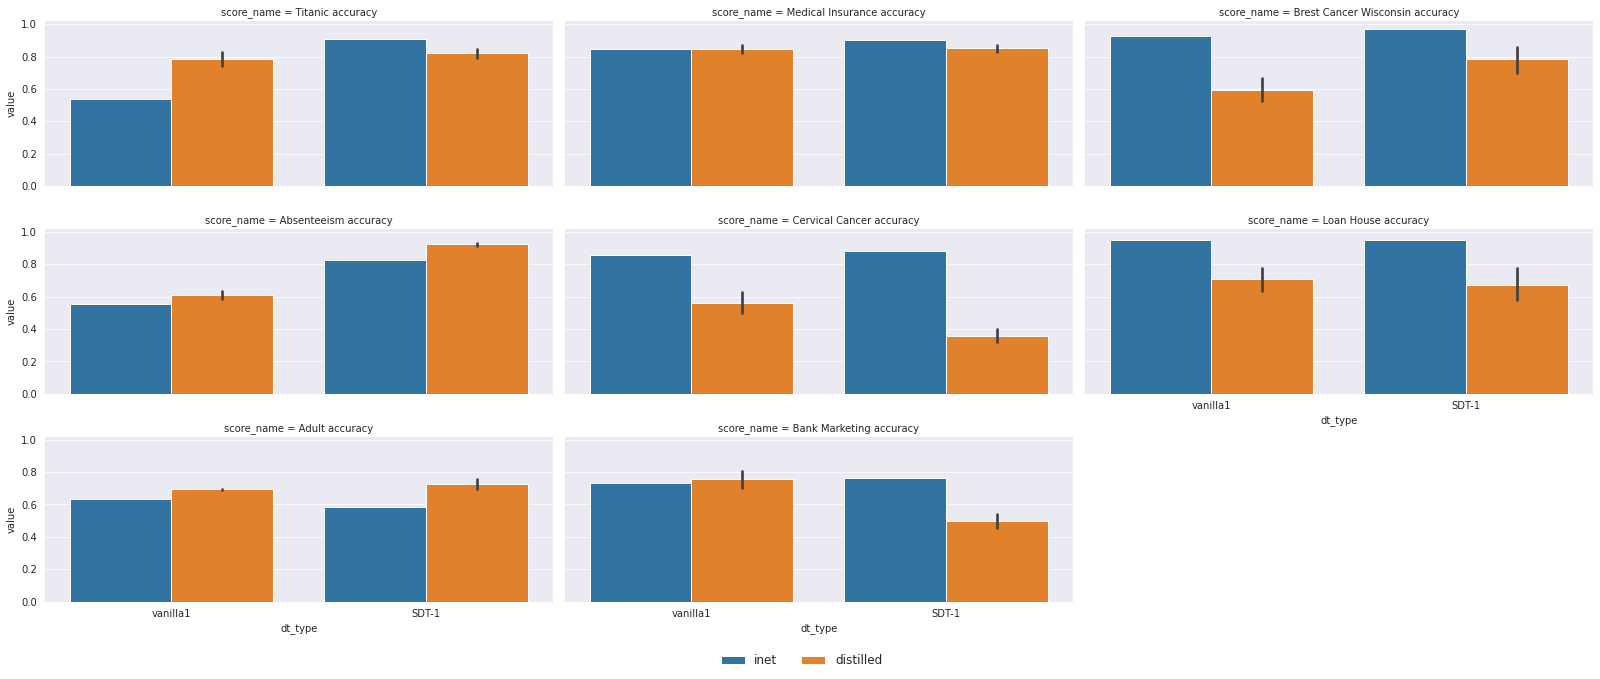

In [31]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'technique', 
                    plot_type = sns.barplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_barplot.pdf', bbox_inches = 'tight', pad_inches = 0)


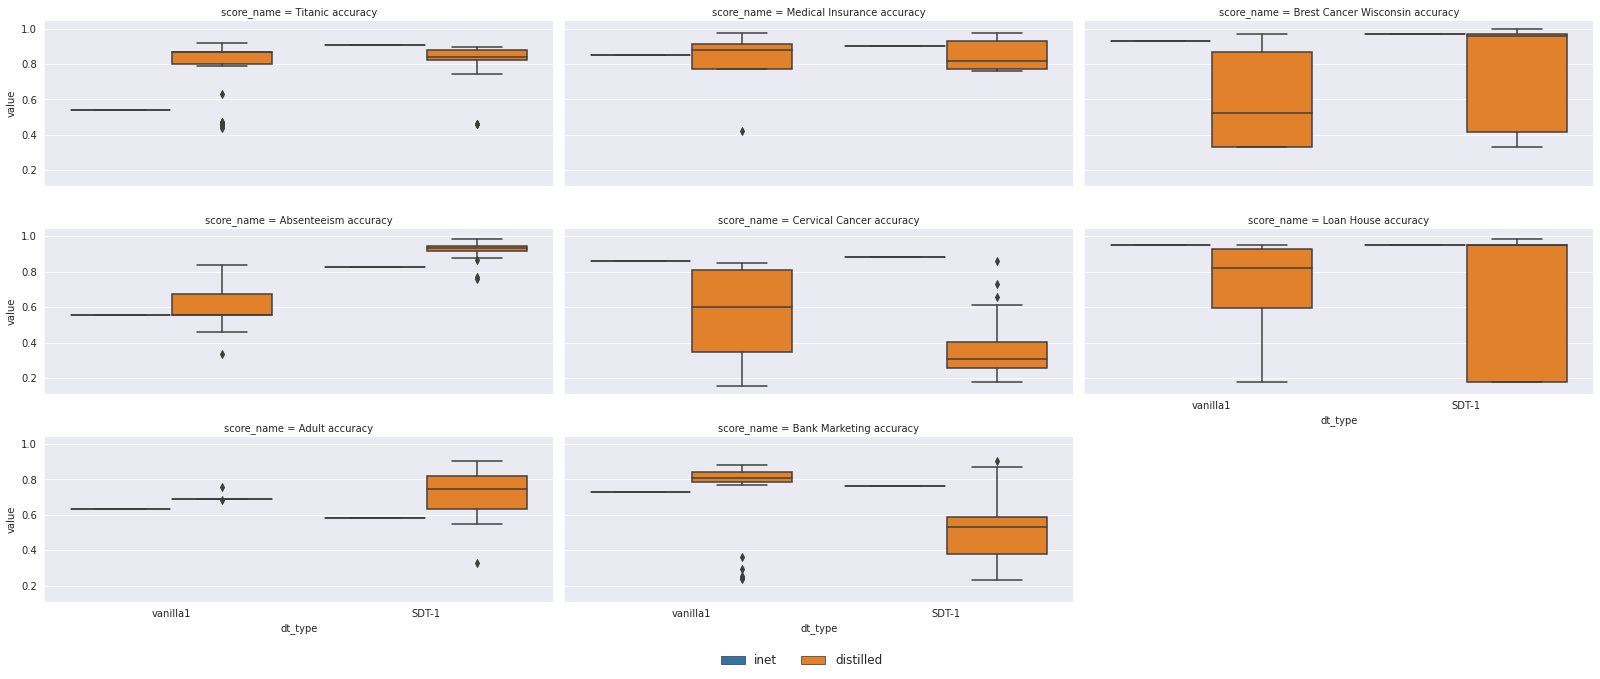

In [32]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'technique', 
                    plot_type = sns.boxplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_boxplot.pdf', bbox_inches = 'tight', pad_inches = 0)


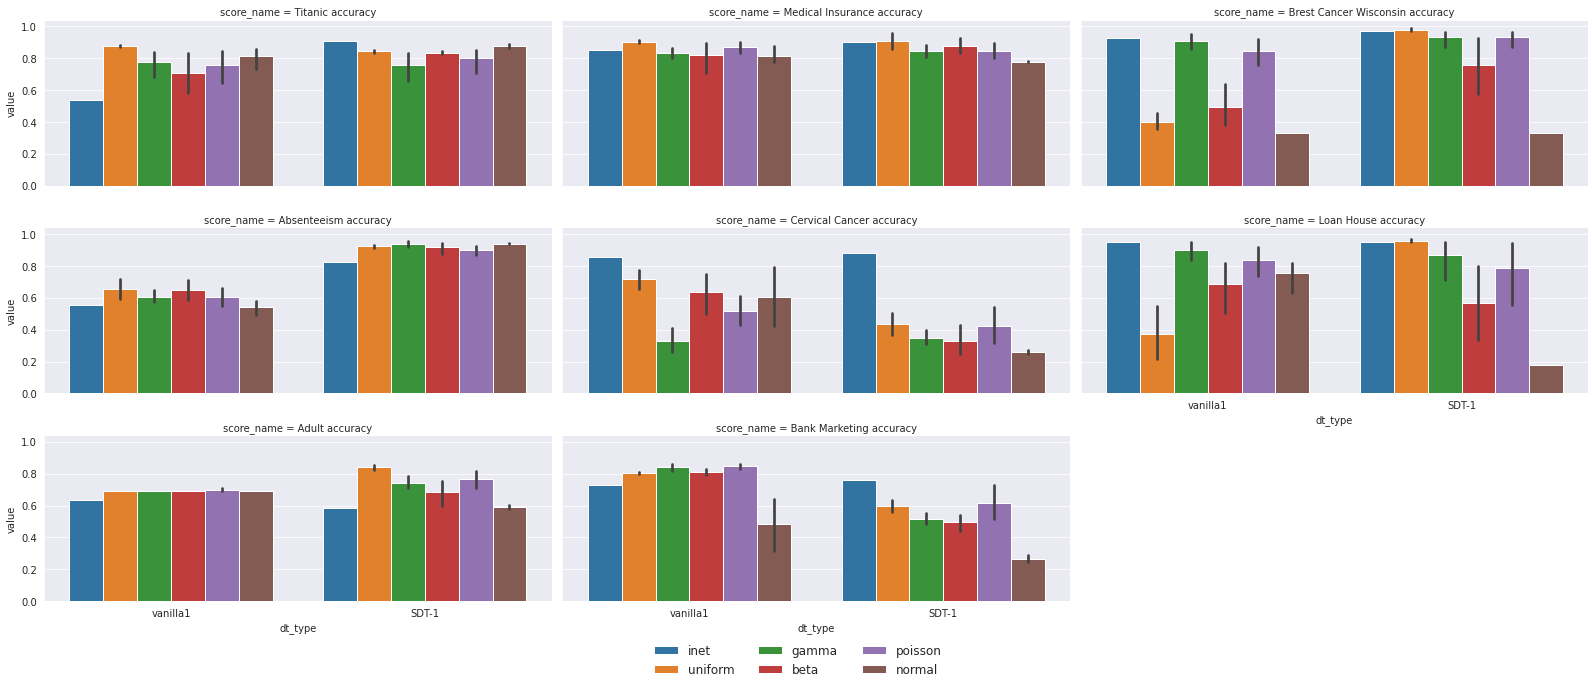

In [33]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'distrib', 
                    plot_type = sns.barplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_by_distrib_barplot.pdf', bbox_inches = 'tight', pad_inches = 0)


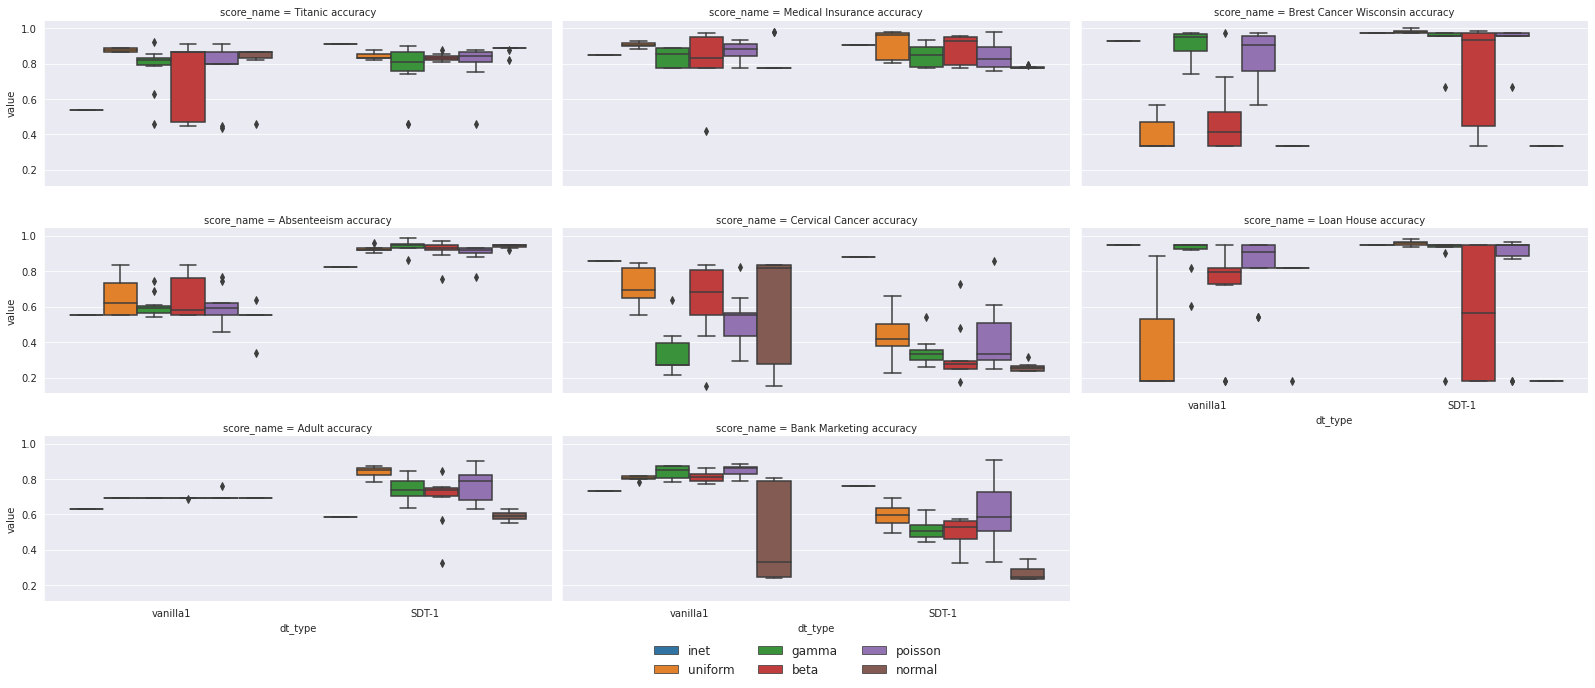

In [34]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'distrib', 
                    plot_type = sns.boxplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_by_distrib_boxplot.pdf', bbox_inches = 'tight', pad_inches = 0)
